# Module list

In [105]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import datetime

!pip install torch-summary
from torchsummary import summary

# Sci Learn & Model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

The system cannot find the path specified.


# Conda check

In [106]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


# Inputs & Variables


In [107]:
#Project Name / AutoML_Table_Wrapper
PROJECT_ID = 'Linear_Regression'

#Bucket Name / AutoML_Table_Wrapper
BUCKET_NAME = 'Arnaud_test'

# display the set-up for pandas dataframe
pd.set_option('display.max_columns', None)

# Train name display / AutoML_Table_Wrapper
DATASET_DISPLAY_NAME='Home_Regression'
MODEL_DISPLAY_NAME = 'Test_model'

# Train CSV dataset - length 1460
train_csv = pd.read_csv("train.csv")

# Test CSV dataset - length 1459
test_csv = pd.read_csv("test.csv")

# submission CSV file
submission = pd.read_csv("sample_submission.csv")

# Directory 
data_dir = ""
train_path = data_dir +'train.csv'
test_path = data_dir +'test.csv'

# Target column / AutoML_Table_Wrapper
target_column = 'SalePrice'

# ID column / AutoML_Table_Wrapper
id_column = 'Id'

# Date and Time
date_res = datetime.datetime.now()

# Define Version
#VERSION = 'version_'+date_res.strftime("%m/%d/%Y")+'.pt'
VERSION = 'HR_0203.pt'

# Train Budget / AutoML_Table_Wrapper
TRAIN_BUDGET = 10

# Train set description

In [108]:
dtf_description = train_csv.describe()
train_csv_head = train_csv.head()
#dtf_description

In [109]:
# Create a list of headers/features that are numerical data
quantitative = [f for f in train_csv.columns if train_csv.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')


In [111]:
# Create a List of headers/features that are qualitative data. 

# List of qualitative data
qualitative = [f for f in train_csv.columns if train_csv.dtypes[f] == 'object']
print('list of qualitative features \n {} \n'. format(qualitative))
# List of qualitative data that have a cardinality inferior to 10
qualitative_card = [f for f in train_csv.columns if train_csv.dtypes[f] == 'object' and train_csv[f].nunique() < 10]
print('list of features with cardinality below 10 \n {} \n'. format(qualitative_card))
# List of qualitative data that have a cardinality superior to 10. This list shall be dropped
qualitative_non_card = [f for f in train_csv.columns if train_csv.dtypes[f] == 'object' and train_csv[f].nunique() > 10]
print('list of features with cardinality above 10\n  {} \n'. format(qualitative_non_card))

list of qualitative features 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

list of features with cardinality below 10 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', '

# Distribution

C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

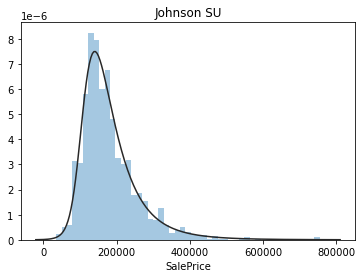

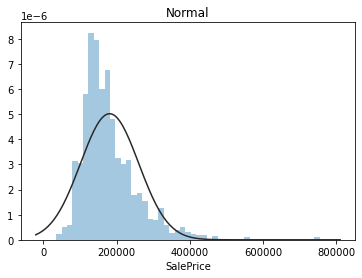

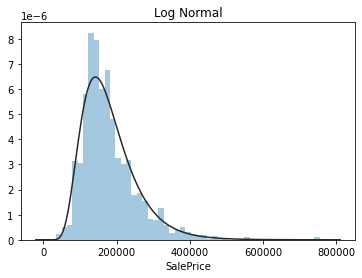

In [112]:
y = train_csv['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

# Test normality

none of quantitative variables has normal distribution so these should be transformed as well.

In [113]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_csv[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


# Data Normalization of sepecific set of features

In [114]:
def norm(dataset, features):
    # Enter a dataset and a list of features
    # Return the dataset with the specific list of features normalized. 
    # !!!! it can normalized only numerical data => Make sure that the list of feature are numerical data
    descri = dataset.describe()
    for feat in features:
        dataset[feat] = dataset[feat].fillna(descri[feat]['mean'])
    dataset[features] = dataset[features].apply(lambda x: (x - x.mean()) / x.std())
    return dataset

# Pearson Correlation
Most widely used correlation on **continuous data** that should be **normally distributed**. It can be applied on numerical data that are normalized.

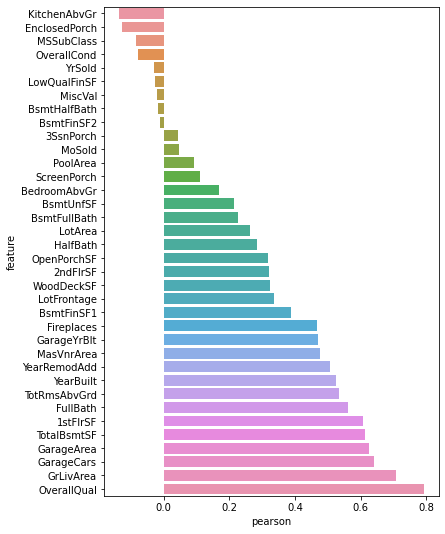

In [115]:
# Calculation of Pearson correlation
def pearson(dataset, features):
    pear = pd.DataFrame()
    pear['feature'] = features
    pear['pearson'] = [dataset[f].corr(dataset['SalePrice'], 'pearson') for f in features]
    pear = pear.sort_values('pearson')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=pear, y='feature', x='pearson', orient='h')

# To be able to use Pearson Correlation, you must normalized the data 1st
train_csv_Norm = norm(train_csv, quantitative)

# Peason correlation of the data that had its quantitative data normalized.
pearson(train_csv_Norm, quantitative)

# Spearman Correlation

Non-parametric test to measure degree of association between two variables.It does NOT carry any assumptions about the distribution of the data and is the appropriate correlation analysis when variables are measured on a scale that is at least **ordinal**. Applicable for the qualitative data once there are encoded in an **ordered** way.


In [116]:
def order(frame, feature):
    # Enter the dataset and the list of features that will need to be ordered
    # !!!! the list of feture must be qualitative data
    # Return:
    # 1. the dataset with the feature ordered against the target label
    # 2. the list of qualitative feature name ordered
    qual_encoded = []
    for f in feature:
        ordering = pd.DataFrame()
        ordering['val'] = frame[f].unique()
        ordering.index = ordering.val
        ordering['spmean'] = frame[[f, 'SalePrice']].groupby(f).mean()['SalePrice']
        ordering = ordering.sort_values('spmean')
        ordering['ordering'] = range(1, ordering.shape[0]+1)
        ordering = ordering['ordering'].to_dict()
        for cat, o in ordering.items():
            frame.loc[frame[f] == cat, f+'_qE'] = o
        qual_encoded.append(f+'_qE')
    return frame, qual_encoded

In [117]:
train_csv_order, qual_order = order(train_csv, qualitative_card)

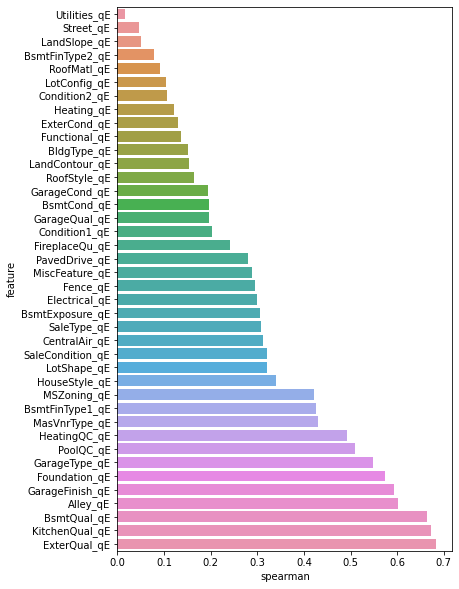

In [118]:
def spearman(frame, features):
    # Enter the dataset and the list of qualitative features that were ordered
    # Print the the graph of the correlation with the target label
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
spearman(train_csv, qual_order)

# Kendall Correlation
Non parametric test that meaure the **strength of dependance** between two variables. 

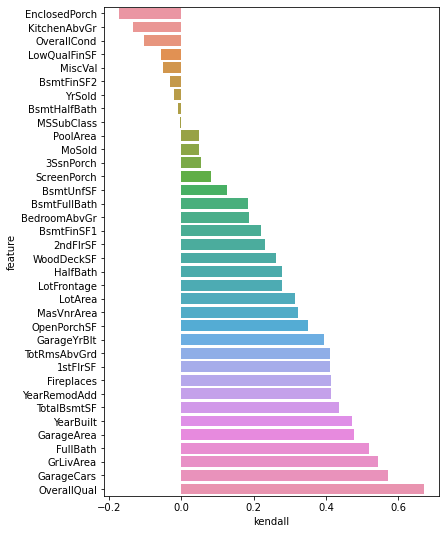

In [119]:
def kendall(frame, features):
    # Enter the
    kend = pd.DataFrame()
    kend['feature'] = features
    kend['kendall'] = [frame[f].corr(frame['SalePrice'], 'kendall') for f in features]
    kend = kend.sort_values('kendall')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=kend, y='feature', x='kendall', orient='h')

kendall(train_csv, quantitative)

# HeatMap

Heatmap correlation of
1. the quantitative data against the Salesprice
2. the qualitative **ordered** data against the Salesprice
3. the quant & qual **ordered** data together against the Salesprice

<AxesSubplot:>

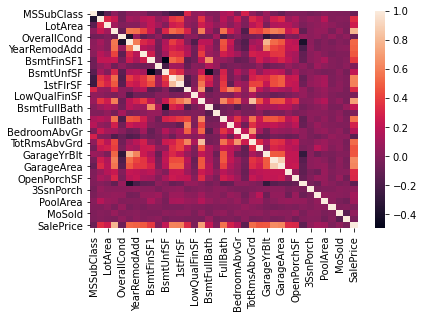

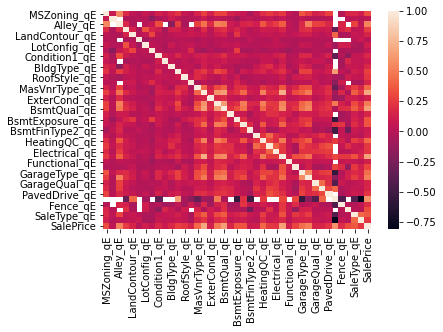

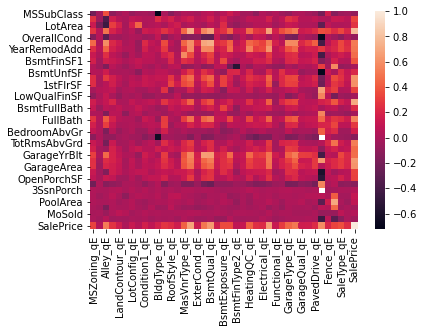

In [121]:
# Heatmap 1
plt.figure(1)
corr = train_csv[quantitative+['SalePrice']].corr()
sns.heatmap(corr)

# Heatmap 2
plt.figure(2)
corr = train_csv[qual_order+['SalePrice']].corr()
sns.heatmap(corr)

# heatmap 3
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_order)+1]), index=quantitative+['SalePrice'], columns=qual_order+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_order+['SalePrice']:
        corr.loc[q1, q2] = train_csv[q1].corr(train_csv[q2])
sns.heatmap(corr)

# Simple Clustering

0.7593037900798071


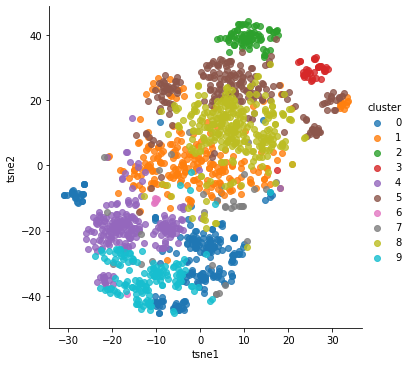

In [125]:
features = quantitative + qual_order
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_csv[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=10)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

0.9845226683711227


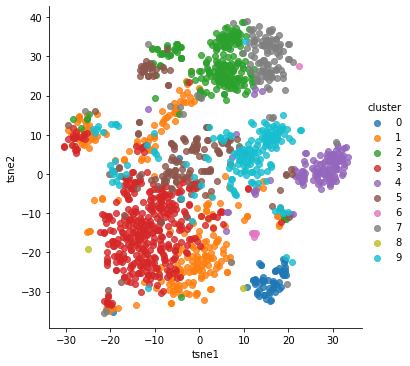

In [126]:
features = quantitative
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_csv[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=10)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

0.9153514276953431


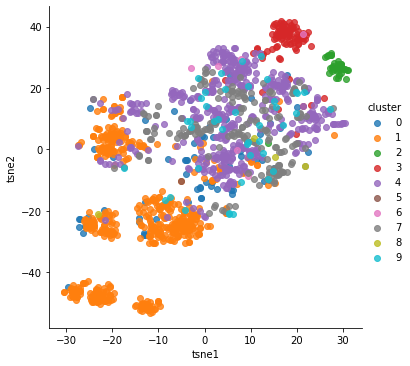

In [127]:
features = qual_order
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_csv[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=10)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

# Number of entries that are null/void

In [32]:
pd.set_option("display.max_rows", 1460)
train_csv_E[quantitative+qual_encoded].isnull().sum()

MSSubClass             0
LotFrontage            0
LotArea                0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
MasVnrArea             0
BsmtFinSF1             0
BsmtFinSF2             0
BsmtUnfSF              0
TotalBsmtSF            0
1stFlrSF               0
2ndFlrSF               0
LowQualFinSF           0
GrLivArea              0
BsmtFullBath           0
BsmtHalfBath           0
FullBath               0
HalfBath               0
BedroomAbvGr           0
KitchenAbvGr           0
TotRmsAbvGrd           0
Fireplaces             0
GarageYrBlt            0
GarageCars             0
GarageArea             0
WoodDeckSF             0
OpenPorchSF            0
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
PoolArea               0
MiscVal                0
MoSold                 0
YrSold                 0
MSZoning_qE            0
Street_qE              0
Alley_qE            1369
LotShape_qE            0


# Function to split training and validation data from the training set

In [9]:
def split_train_valid_data(data, perc=0.75):
    # Enter the data set and the % of the dataset that will be kept
    # Return the dataset of the remainign %
    return data.head(int(len(data)*(perc)))
    


# Data Processing

1. Merge the training and dataset because if we do one-hot encoding and that a cardinality is present in one set and not the other, then the prediction will never work correctly. In other word, the model will not be trained on the same set.
2. 

# Creation of the Dataloader

In [10]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_data, csv_file_test, id_col, target_col, data=None):
        self.data_train= pd.read_csv(csv_file_data)
        self.data_test = pd.read_csv(csv_file_test)
        self.id        = id_col
        self.target    = target_col
        self.data = data

    def __len__(self):
        if self.data == 'train':
            return len(self.data_train)
        else:
            return len(self.data_test)

    def __getitem__(self, idx):
        # remove the target column
        train_wo_SP = self.data_train.drop(self.target, axis='columns')
        # concat train and test features to have the same number of columns one the dummies features appear
        all_features = pd.concat([train_wo_SP, self.data_test], keys=["train", "test"])
        descri = all_features.describe()
        numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
        for feat in numeric_features:
            all_features[feat] = all_features[feat].fillna(descri[feat]['mean'])
        # Normalize the numerical features
        all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
        
        # creathe the dummies for train and test set
        all_features_dummies = pd.get_dummies(all_features)
        
        # creation of the label of train dataset
        train_label1 = self.data_train['Id']
        train_label2 = self.data_train['SalePrice']
        train_label = pd.DataFrame(columns = ['Id', 'SalePrice'])
        train_label['Id'] = train_label1
        train_label['SalePrice'] = train_label2
        
        #print(train_label)

        #Split Data - creation of the Validation dataset
        train_data = split_train_valid_data(all_features_dummies.loc['train'])
        valid_data = all_features_dummies.loc['train'].iloc[max(train_data.index+1):]

        
        #Split label - creation of the validation labelset
        label_train = split_train_valid_data(train_label)
        label_valid = train_label.iloc[max(train_data.index+1):]
         
        # creation of the test data set
        test_data = all_features_dummies.loc['test']
        
        # creation of an Empty label test
        label_test = pd.DataFrame(np.empty((test_data.shape[0],1)))
        
        train_data = train_data.astype(np.float32)
        valid_data = valid_data.astype(np.float32)
        test_data = test_data.astype(np.float32)
        label_train = label_train.astype(np.float32)
        label_valid = label_valid.astype(np.float32)
        
        # remove 'ID' columns - data
        train_data = train_data.drop(['Id'], axis=1)
        #print(len(train_data))
        valid_data = valid_data.drop(['Id'],axis=1)
        #print(len(valid_data))
        test_data = test_data.drop(['Id'], axis=1)
        #print(len(test_data))
        
        # remove 'ID' column - label
        label_train = label_train.drop(['Id'], axis=1)
        label_valid = label_valid.drop(['Id'], axis=1)
            
        # data preparation
        if self.data == 'train':
            use_data = train_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'valid':
            use_data = valid_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'test':
            use_data = test_data.to_numpy()
            use_data = torch.from_numpy(use_data)
            
        # label preparation
        if self.data == 'train':
            label_data = label_train.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'valid':
            label_data = label_valid.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'test':
            label_data = label_test.to_numpy()
            label_data = torch.from_numpy(label_data)
        
        return use_data, label_data

params = {
    'id_col':'Id',  
    'target_col': ['SalePrice'],
}

In [11]:
data_dataset = {x: CustomDataset(csv_file_data=data_dir+'train.csv', 
                                 csv_file_test=data_dir+'test.csv', 
                                 **params, 
                                 data='train' if x == 'train' 
                                 else 'valid' if x =='valid' 
                                 else 'test') 
                for x in ['train', 'valid', 'test']
               }


In [12]:
data_pg, lab_target_pg = data_dataset['test'].__getitem__(1)
print(data_pg)

tensor([[-0.8735,  0.5018,  0.1843,  ...,  0.0000,  1.0000,  0.0000],
        [-0.8735,  0.5487,  0.5197,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0673,  0.2203,  0.4643,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [-0.8735,  4.2555,  1.2466,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6553, -0.3428,  0.0346,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0673,  0.2203, -0.0686,  ...,  0.0000,  1.0000,  0.0000]])


In [13]:
data_loader = {x :torch.utils.data.DataLoader(data_dataset[x], batch_size=1, shuffle=True)
                for x in ['train', 'valid', 'test']}

In [14]:
print('TRAINING')

data, lab_target = data_dataset['train'].__getitem__(0)

print('DATASET')
print('Data shape: ', data.shape)
print('Data type: ', type(data))
print('Data size: {}'.format(data.size()))
#print('Exampe of the feature for the 1st entry {}'.format(data[0]))
print('\nTarget at the first row: {}'.format(lab_target.size()))
print('Example of the label for the 1st entry: {}'.format(lab_target[0]))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

datas, labels_target = train_iter.next()

print('DATALOADER')
print('images shape on batch size = ', datas.size())
print('Example of datas for the 1st entry {}'.format(datas[0].size()))
#print('\nTaregt type on batch size = {}'.format(labels_target))
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)
print(len(train_iter))

TRAINING
DATASET
Data shape:  torch.Size([1095, 288])
Data type:  <class 'torch.Tensor'>
Data size: torch.Size([1095, 288])

Target at the first row: torch.Size([1095, 1])
Example of the label for the 1st entry: tensor([208500.])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
DATALOADER
images shape on batch size =  torch.Size([1, 1095, 288])
Example of datas for the 1st entry torch.Size([1095, 288])
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([1, 1095, 1])
1460


# Model creation

In [15]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define linear layers
        
        # linear layer (330 -> 755001)
        self.fc1 = nn.Linear(288, 1)
        # linear layer (500 -> 250)
        #self.fc2 = nn.Linear(100, 50)
        # linear layer (250 -> 125)
        #self.fc3 = nn.Linear(50, 1)

        #self.dropout = nn.Dropout(0.1)
        
        # LogSoftmax
        self.RELU = nn.ReLU()
    
    def forward(self, x):
        
        #print('before l1 {}'.format(x))
        # 1LL
        x = self.RELU(self.fc1(x))
        #x = self.dropout(x)
        
        #print('before l2 {}'.format(x))
        # 2LL
        #x = torch.tanh(self.fc2(x))
        #x = self.dropout(x)
        
        #print('before l3 {}'.format(x))
        # 3LL
        #x = self.fc3(x)
        
        #print('After LR {}'.format(x))
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_HR = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_HR.cuda()

In [16]:
model_HR

Net(
  (fc1): Linear(in_features=288, out_features=1, bias=True)
  (RELU): ReLU()
)

In [17]:
next(model_HR.parameters()).is_cuda

False

# Torch Summary

In [18]:
summary(Net(),input_size=(1, 288))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            289
├─ReLU: 1-2                              --
Total params: 289
Trainable params: 289
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            289
├─ReLU: 1-2                              --
Total params: 289
Trainable params: 289
Non-trainable params: 0

In [28]:
#Learning rate
lr=0.01

#momentum
momentum = 0.8

### select loss function
criterion = nn.MSELoss()

# other Loss function
# 1-MSE
#criterion = nn.MSELoss()

# 2-Mae
def mae(true, pred):
    return np.sum(np.abs(true - pred))
# or
#criterion = nn.L1Loss()

# 3-huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

# 4-log cosh loss
def logcosh(true, pred):
    loss = np.log(np.cosh(pred - true))
    return np.sum(loss)

# 5-Quantile Loss / Note: the Quantile Loss is not define yet

### select optimizer


optimizer = optim.ASGD(model_HR.parameters(), lr=lr)

#other otpions: 
# SGD
# optim.SGD(model_HR.parameters(), lr=lr, momentum = momemtum)
# Sparse Adam - In this variant, only moments that show up in the gradient get updated, and only those portions of the gradient get applied to the parameters.
# optim.SparseAdam(model_HR.parameters(), lr=lr)
# Average Stochastic gradient descent
# optim.ASGD(model_HR.parameters(), lr=lr)
# RMSprop
# optim.RMSprop(model_HR.parameters(), lr=lr, momentum = momentum)



In [29]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            '''for name, param in model.named_parameters(): 
                if param.requires_grad: 
                    print(name, param.data)'''
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = criterion(output, target)           

        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = criterion(output, target)
        
        # Next todo, create a variable lr according to validation loss
        '''if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001'''
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            lr
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # return trained model
    return model

Epoch: 1 	Training Loss: 563754560.000000 	Validation Loss: 1563424000.000000 	Time since the beginning 15.4 min 	Learning rate: 0.010000 
Validation loss decreased (inf --> 1563424000.000000).  Saving model ...
Epoch: 2 	Training Loss: 517497696.000000 	Validation Loss: 1552157440.000000 	Time since the beginning 29.8 min 	Learning rate: 0.010000 
Validation loss decreased (1563424000.000000 --> 1552157440.000000).  Saving model ...
Epoch: 3 	Training Loss: 495772960.000000 	Validation Loss: 1560775040.000000 	Time since the beginning 44.1 min 	Learning rate: 0.010000 
Epoch: 4 	Training Loss: 482823392.000000 	Validation Loss: 1572220288.000000 	Time since the beginning 58.5 min 	Learning rate: 0.010000 
Epoch: 5 	Training Loss: 474017056.000000 	Validation Loss: 1583784320.000000 	Time since the beginning 72.7 min 	Learning rate: 0.010000 


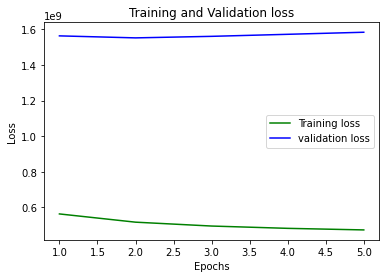

In [30]:
model_res = train(5, data_loader, model_HR, optimizer, criterion)

# Train with custon dataset

In [31]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            '''for name, param in model.named_parameters(): 
                if param.requires_grad: 
                    print(name, param.data)'''
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = criterion(output, target)           

        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = criterion(output, target)
        
        # Next todo, create a variable lr according to validation loss
        '''if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001'''
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            lr
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # return trained model
    return model

In [32]:
model_res = train(10, data_dataset, model_HR, optimizer, criterion)

KeyboardInterrupt: 

# Result and submission file

In [33]:

print(len(data_loader['test']))
dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
datas, labels = dataiter_test.next()
print('images\n',datas.shape)
print('labels\n',labels.shape)

model_test = model_HR
model_test.load_state_dict(torch.load(VERSION))
model_test = model_test.eval()
print(model_test)

if use_cuda:
    datas = datas.cuda()
out_fwd = model_test.forward(datas)
print(out_fwd)
#print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
#probs = torch.exp(out_fwd)
#print('probs\n', probs)
#print(probs.max())
#print(probs.min())

1459
data_iter
images
 torch.Size([1, 1459, 288])
labels
 torch.Size([1, 1459, 1])
Net(
  (fc1): Linear(in_features=288, out_features=1, bias=True)
  (RELU): ReLU()
)
tensor([[[114769.9062],
         [163673.1406],
         [181656.6250],
         ...,
         [177801.9844],
         [119087.3750],
         [228039.9844]]], grad_fn=<ReluBackward0>)


In [34]:
for i in range(len(out_fwd)):
    submission.iloc[i][1] = out_fwd[i][0]

pd.set_option("display.max_rows", 10, "display.max_columns", None)

submission.to_csv(path_or_buf='sample_submission_'+VERSION+'.csv', index=False)

C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Score

result: - Ranking: 